In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from trackpy.preprocessing import bandpass

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


In [2]:
X = sorted(glob('data/img/*.tif'))
Y = sorted(glob('data/labels/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [4]:
def preprocess(X, Y):
    X = [normalize(x,1,99.8,axis=(0,1)) for x in tqdm(X)] #(0,1) normalizes axes independently
    Y = [fill_label_holes(y) for y in tqdm(Y)]
    
    return X, Y

In [5]:
X, Y = preprocess(X,Y)

100%|██████████| 25/25 [00:00<00:00, 608.55it/s]


In [6]:
def augmenter(X, Y):
    X_augmented = []
    Y_augmented = []
    for img, label in zip(X,Y):
        X_augmented.append(img)
        X_augmented.extend([np.rot90(img,n) for n in [1,2,3]])
        X_augmented.extend([np.flipud(img), np.fliplr(img)])
        
        Y_augmented.append(label)
        Y_augmented.extend([np.rot90(label,n) for n in [1,2,3]])
        Y_augmented.extend([np.flipud(label), np.fliplr(label)])
        
    return X_augmented, Y_augmented

In [7]:
X, Y = augmenter(X, Y)
len(X)

150

In [8]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 150
- training:       128
- validation:      22


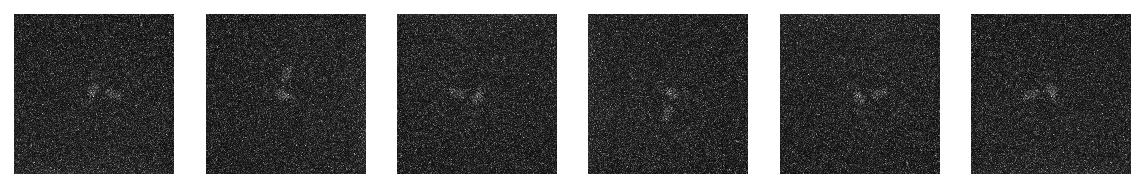

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(161); plt.imshow(X[0],cmap='gray', clim=(np.min(X[0]),np.max(X[0]))); plt.axis('off');
plt.subplot(162); plt.imshow(X[1],cmap='gray', clim=(np.min(X[1]),np.max(X[1]))); plt.axis('off');
plt.subplot(163); plt.imshow(X[2],cmap='gray', clim=(np.min(X[2]),np.max(X[2]))); plt.axis('off');
plt.subplot(164); plt.imshow(X[3],cmap='gray', clim=(np.min(X[3]),np.max(X[3]))); plt.axis('off');
plt.subplot(165); plt.imshow(X[4],cmap='gray', clim=(np.min(X[4]),np.max(X[4]))); plt.axis('off');
plt.subplot(166); plt.imshow(X[5],cmap='gray', clim=(np.min(X[5]),np.max(X[5]))); plt.axis('off');

In [10]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (4,4)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(4, 4), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (4, 4),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor':

In [11]:
model = StarDist2D(conf, name='gcamp-stardist', basedir='models')

W1013 18:38:40.918804 139906162542400 deprecation_wrapper.py:119] From /home/ubuntu/miniconda3/envs/stardist/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1013 18:38:40.933402 139906162542400 deprecation_wrapper.py:119] From /home/ubuntu/miniconda3/envs/stardist/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1013 18:38:40.934475 139906162542400 deprecation_wrapper.py:119] From /home/ubuntu/miniconda3/envs/stardist/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1013 18:38:40.960758 139906162542400 deprecation_wrapper.py:119] From /home/ubuntu/miniconda3/envs/stardist/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool 

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [12]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

W1013 18:38:41.390712 139906162542400 deprecation_wrapper.py:119] From /home/ubuntu/miniconda3/envs/stardist/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3005: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1013 18:38:41.392833 139906162542400 deprecation_wrapper.py:119] From /home/ubuntu/miniconda3/envs/stardist/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [13]:
%%capture train_log
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=None)

In [14]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:05<00:01,  2.66it/s, 0.551 -> 0.918]


Using optimized values: prob_thresh=0.548407, nms_thresh=0.3.
Saving to 'thresholds.json'.
